# Разработка A/B-тестирования и анализ результатов

Автор: Каримова Эльвира Ильгизовна 🙂

## Введение
Для данного проекта необходимо было провести оценку эффективности нового алгоритма рекомендательной системы в развлекательном приложении с бесконечной лентой контента, аналогичном платформам с короткими видео.

Приложение использует две модели монетизации:

- **Платная подписка** — пользователи без рекламы.
- **Бесплатный доступ** — с показом рекламы.

Команда разработчиков предложила новый алгоритм рекомендаций, который, по их гипотезе, показывает более релевантный контент и повышает вовлечённость. Моя задача — спроектировать и проанализировать A/B-тест, чтобы проверить эту гипотезу.

## Цель и задачи  

- Цель теста: оценить **эффективность нового алгоритма рекомендаций**.
- Целевая метрика: **доля успешных сессий**, в которых пользователь просмотрел 4 и более страниц - `показатель вовлеченности контента`.
- Гипотеза: новый алгоритм повысит вовлеченность пользователь -> **увеличит долю "успешных сессий"**.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных, проверить отсутствие пересечения между группами.
3. Сформулировать продуктовую гипотезу.
4. Выбрать целевую метрику.
5. Выбрать стат.параметры, аудиторию, длительность эксперимента и разделить на группы.
6. Подсчитать метрики, проверить стат.значимость и провести выбранный стат.тест. 
7. Интерпретировать результаты и принять решения.

## Описание данных

Перед нами три таблицы:

- Таблица 1 — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23.

- Таблица 2 — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- Таблица 3 — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
Работа  с историческими данными приложения:

- Импортиртируем библиотеку pandas.

- Считаем и сохраняем в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей.

Выводим на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

# Загружаем библиотеки для стат.тестов
from statsmodels.stats.power import NormalIndPower
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные в переменную sessions_history
sessions_history = pd.read_csv(..............................)

# Выводим строки датафрейма на экран
(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [3]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [4]:
# Переводим нужные столбцы в формат "дата"
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date']).dt.normalize()
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date']).dt.normalize()

# Переводим нужный столбец в формат "дата и время"
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])

In [5]:
# Проверяем типы данных
(sessions_history.dtypes)

user_id                      object
session_id                   object
session_date         datetime64[ns]
session_start_ts     datetime64[ns]
install_date         datetime64[ns]
session_number                int64
registration_flag             int64
page_counter                  int64
region                       object
device                       object
dtype: object

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выводим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выбираем любого из них.

- Изучаем таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [6]:
# Рассчитаем для каждого уникального пользователя количество уникальных сессий
# Группируем по user_id и посчитаем количество уник.session_id
session_counts = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
session_counts.columns = ['user_id', 'session_count']

# Сортируем по убыванию, чтобы найти пользователя с наибольшим числом сессий
session_counts = session_counts.sort_values(by='session_count', ascending=False)

# Выводим топ-5 для проверки
(session_counts.head())

,user_id,session_count
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9


In [7]:
# Выбираем пользователя с наибольшим количеством сессий
top_user_id = session_counts.iloc[0]['user_id']

# Фильтруем исходную таблицу, оставляя только данные этого пользователя
user_data = sessions_history[sessions_history['user_id']==top_user_id]

# Выводим все данные по этому пользователю
(user_data.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android


#### Промежуточные выводы

Пользователь с наибольшим количеством сессий найден и это - `10E0DEFC1ABDBBE0`, у которого **10 сессий** в приложении в период `2025-08-14 по 2025-08-25`.

- Пользователь **регулярно возращается** в приложение
- У него **высокая вовлеченность**
- Является **ключевым пользователем**, возможно является **потенциальным фанатом продукта**

Из полученной таблицы можно увидеть, что установка произошла `2025-08-14`, и в этот же день была 1я сессия.
В течение `11 дней`, пользователь открывал приложение, почти что ежедневно.
Все сессии происходили с устройства `Android`.
Однако, данный пользователь остается незарегистрированным пользователем, помимо этого просматривает в среднем `2-3 страницы за сессию` и у него регион `CIS`.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты посчитаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

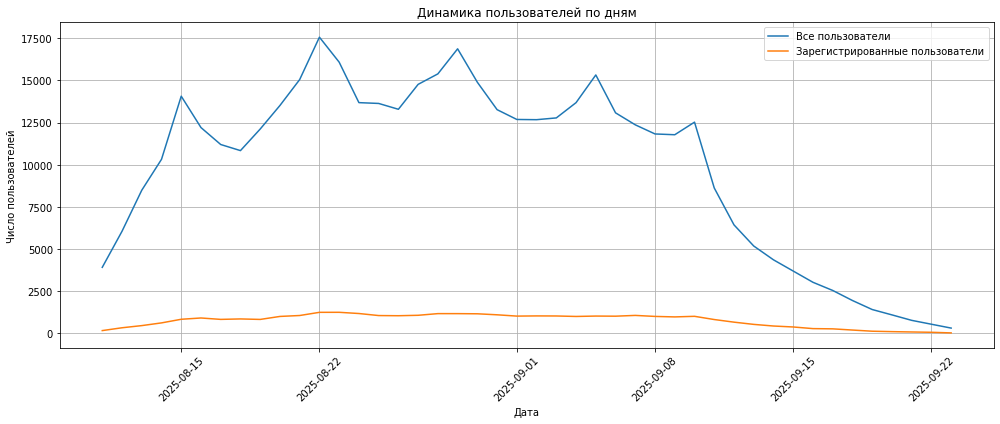

In [8]:
# Сгруппируем данные по сессии
daily_data = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum'))

# Строим графики
plt.figure(figsize=(14, 6))

plt.plot(daily_data.index, daily_data['total_users'], label='Все пользователи')
plt.plot(daily_data.index, daily_data['registered_users'], label='Зарегистрированные пользователи')

# Оформление
plt.title('Динамика пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

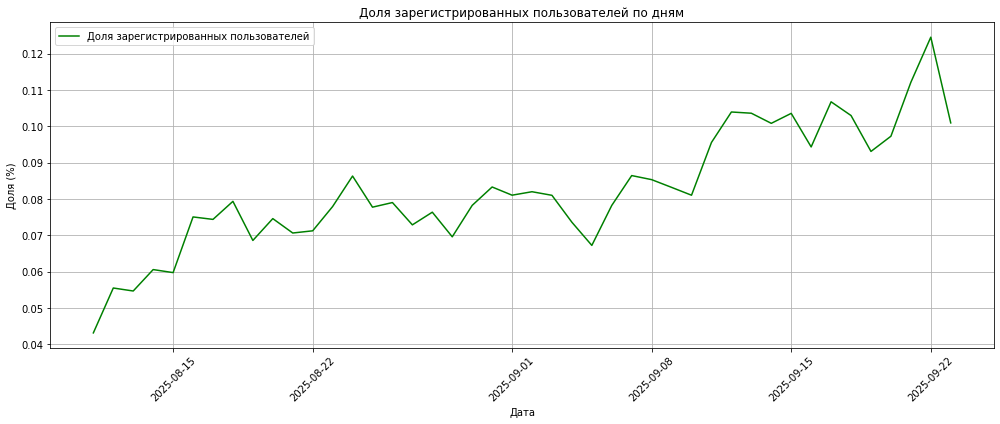

In [9]:
# Вычисляем долю зарегистрированных
daily_data['reg_ratio'] = daily_data['registered_users'] / daily_data['total_users']

# Строим график доли
plt.figure(figsize=(14, 6))

plt.plot(daily_data.index, daily_data['reg_ratio'], color='green', label='Доля зарегистрированных пользователей')

# Оформляем графики
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Показываем график
plt.show()

#### Промежуточные выводы

На графике 1 показано количество **всех пользователей** (синяя линия) и **зарегистрированных пользователей** (оранжевая линия) за каждый день.

- Общее число пользователей `total_users` практически постоянное, около `130 000 пользователей в день`. Динамика стабильная, без резких пиков или спадов.
- Число зарегистрированных пользователей `registered_users` крайне мало, около `500 пользователей в день`.

Из этого можно сделать вывод:
- **Низкая активность** - большинство пользователей не регистрируются в приложении, возможно нет мотивации, или возникают сложности в процессе регистрации.
- **Стабильная аудитория** - несмотря на отсутствие регистрации, общее число пользователей остается стабильным.
- **Потенциал для улучшений** - в связи с низким уровнем регистрации, возникает возможность оптимизировать процесс регистрации или добавления инструментов, которые поспособствуют дальнейшей регистрации.


На графике 2 отображена **доля зарегистрированных пользователей** от общего числа пользователей.

Доля стартует с небольшого значения `~0.001` и достигает макс. `~0.12`, затем снижается к концу периода.

Из этого можно сделать вывод:
- Доля регистрации - определенно существует некая проблема с регистрацией.
- Тенденция снижения - после достижения пика доля зарегистрированных пользователей падает, возможно это связано с изменением трафика, изменение интерфейса или функционала приложения, влияние сезонных факторов или внешних событий.
- Необходимость анализа причин - главный вопрос: **почему пользователи не регистрируются, как можно повысить данный показатель**?

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [10]:
# Сгруппируем по page_counter и посчитаем количество сессий
page_distribution = sessions_history['page_counter'].value_counts().sort_index()

# Выводим на экран таблицу
(page_distribution)

1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: page_counter, dtype: int64

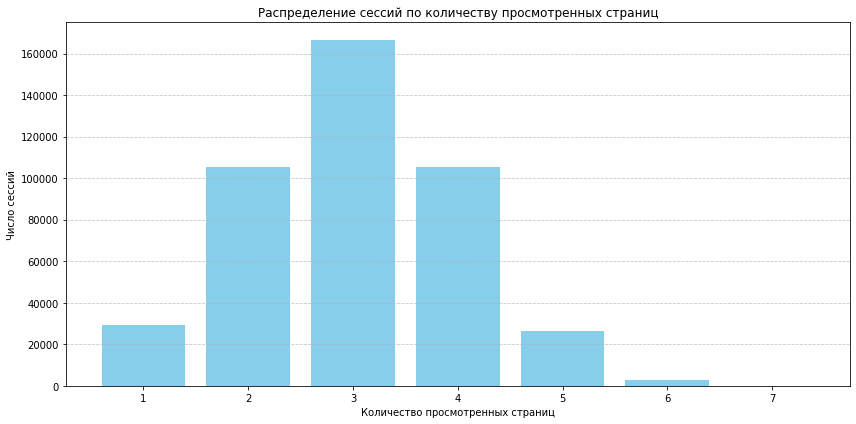

In [11]:
# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
plt.bar(page_distribution.index, page_distribution.values, color='skyblue')

# Оформляем графики
plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Число сессий')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(page_distribution.index)

# Показываем график
plt.tight_layout()
plt.show()

#### Промежуточные выводы

На графике 3 показано распределение сессий по количеству просмотренных страниц, где по оси Х - количество просмотренных страниц `page_counter`, а по оси Y - число сессий, в которых было просмотрено соответвующее количество страниц.

Пик приходится на 3 просмотренные страницы, что означает, что большинство пользователей просматривают именно **3 страницы за одну сессию**.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создаем дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

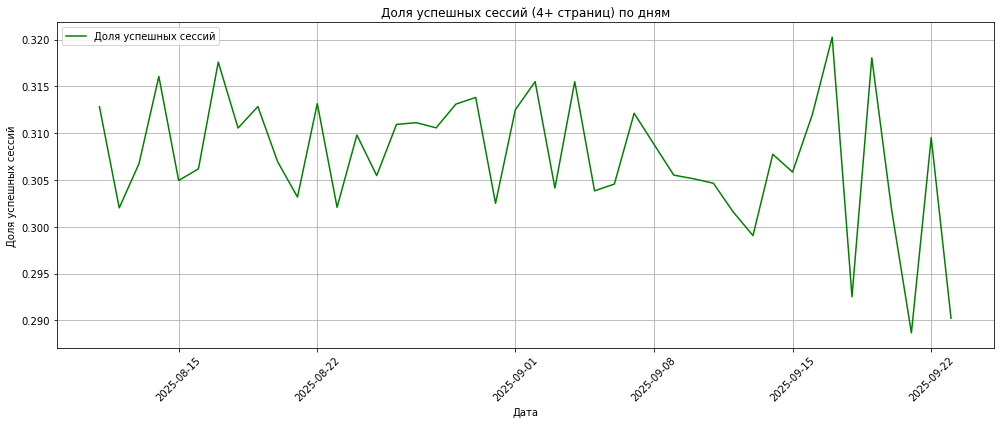

In [12]:
# Создаем новый столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >=4).astype(int)

# Сгруппируем по дате сессии и посчитаем метрики
daily_good_sessions = (
    sessions_history
    .groupby('session_date')
    .agg(total_sessions=('good_session', 'count'),
         good_sessions=('good_session', 'sum')
        )
)

# Вычисляем долю успешных сессий
daily_good_sessions['good_session_ratio']=daily_good_sessions['good_sessions'] / daily_good_sessions['total_sessions']

# Строим график
plt.figure(figsize=(14, 6))
plt.plot(
    daily_good_sessions.index,
    daily_good_sessions['good_session_ratio'],
    color='green',
    label='Доля успешных сессий'
)

# Оформление графика
plt.title('Доля успешных сессий (4+ страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Показываем график
plt.show()

#### Промежуточные выводы

На графике 4 показана доля успешных сессий, где за одну сессию было просмотрено 4 и более страниц.

- **Общая тенденция** - средняя доля успешных сессий находится в диапазоне `0.3-0.315`, то есть `30-31.5%` сессий соответствуют критерию **удовлетворенности контентом**.
- **Периодические пики/спады** - наблюдаются колебания, которые могут быть вызваны изменениями в алгоритме рекомендаций, маркетинговыми кампаниями, акциями, сезонными факторами или изменениями в интерфейсе.
- **Значительное снижение к концу периода** - ближе к октябрю/ноябрю, доля успешных сессий падает до `0.29`, то есть `29%` сессий, возможно ухудшилось качество рекомендаций, возможные проблемы с контентом либо просто сезонный спад активности.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки

Устанавливаем следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. 

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [13]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

'Необходимый размер выборки для каждой группы: 17441'

#### 2.1. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [14]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Размер выборки на одну группу
sample_size_per_group = 17441

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size_per_group / (avg_daily_users / 2))

(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {int(avg_daily_users)} пользователей в день составит {test_duration} дня")

'Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 4 дня'

#### Промежуточные выводы


- Целевая метрика - для оценки эффективности нового алгоритма рекомендаций была выбрана **доля сессий, в которых пользователь просмотрел 4 и более страниц**, показатель вовлеченности контента. 

`чем выше это доля - тем лучше работает алгоритм`

- Основные параметры теста - `alpha = 0.05, power = 0.8, MDE = 0.03`
- Необходимый размер выборки - `17441`
- Среднее количество уникальных пользователей в день - `9907`

Для того, чтобы тест был статистически корректным и мог надежно обнаружить эффект в `3%`, необходимо набрать `17441` пользователей в каждую группу, и для этого потребуется `~4дня`.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

- Считаем и сохраняем в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [15]:
# Загружаем данные теста
sessions_test_part = pd.read_csv(............................)

# Проверяем, как выглядит таблица
(sessions_test_part.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [16]:
# Выводим информацию о датафрейме
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


In [17]:
# Переводим нужные столбцы в формат "дата"
sessions_test_part['session_date'] = pd.to_datetime(sessions_test_part['session_date']).dt.normalize()
sessions_test_part['install_date'] = pd.to_datetime(sessions_test_part['install_date']).dt.normalize()

# Переводим нужный столбец в формат "дата и время"
sessions_test_part['session_start_ts'] = pd.to_datetime(sessions_test_part['session_start_ts'])

In [18]:
# Проверяем типы данных
(sessions_test_part.dtypes)

user_id                      object
session_id                   object
session_date         datetime64[ns]
session_start_ts     datetime64[ns]
install_date         datetime64[ns]
session_number                int64
registration_flag             int64
page_counter                  int64
region                       object
device                       object
test_group                   object
dtype: object

In [19]:
# Выбираем данные только за нужный день
first_day = sessions_test_part[sessions_test_part['session_date']=='2025-10-14']

# Рассчитаем уникальных пользователей в каждой группе
users_by_group = first_day.groupby('test_group')['user_id'].nunique()

# Выводим результат
(users_by_group)

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [20]:
# Получаем значения
a = users_by_group['A']
b = users_by_group['B']

# Считаем процентную разницу
percentage_diff = 100 * abs(a-b)/a

# Выводим результат
(f"Процентная разница между группами: {percentage_diff:.2f}%")

'Процентная разница между группами: 0.74%'

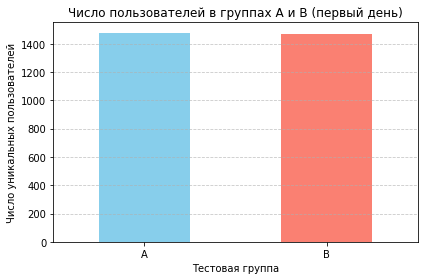

In [21]:
# Строим столбчатую диаграмму
users_by_group.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(6, 4))

# Оформление графика
plt.title('Число пользователей в группах A и B (первый день)')
plt.xlabel('Тестовая группа')
plt.ylabel('Число уникальных пользователей')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображаем график
plt.tight_layout()
plt.show()

#### 3.2. Проверка пересечений пользователей

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, убедимся, что таких нет.

In [22]:
# Сгруппируем по user_id и соберем уникальные группы, в которых он встречается
user_groups = sessions_test_part.groupby('user_id')['test_group'].nunique()

# Оставляем только тех, кто встречается в обеих группах
overlap_users = user_groups[user_groups == 2].index

# Выводим количество таких пользователей
num_overlap = len(overlap_users)
(f"Количество пользователей, попавших и в группу А, и в группу В: {num_overlap}")

'Количество пользователей, попавших и в группу А, и в группу В: 0'

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.

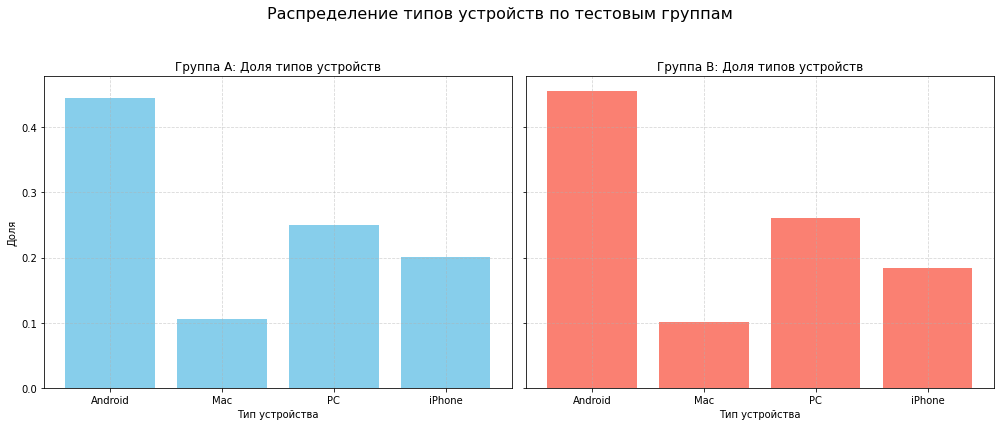

In [23]:
# Разделяем пользователей по группам
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Считаем доли устройств для каждой группы
device_dist_a = group_a.groupby('device')['user_id'].nunique().sort_index()
device_dist_b = group_b.groupby('device')['user_id'].nunique().sort_index()

# Нормализуем, чтобы получить доли
device_dist_a = device_dist_a / device_dist_a.sum()
device_dist_b = device_dist_b / device_dist_b.sum()

# Настройка графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Группа A
axes[0].bar(device_dist_a.index, device_dist_a.values, color='skyblue')
axes[0].set_title('Группа A: Доля типов устройств')
axes[0].set_ylabel('Доля')
axes[0].set_xlabel('Тип устройства')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Группа B
axes[1].bar(device_dist_b.index, device_dist_b.values, color='salmon')
axes[1].set_title('Группа B: Доля типов устройств')
axes[1].set_xlabel('Тип устройства')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Общий заголовок
plt.suptitle('Распределение типов устройств по тестовым группам', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. 

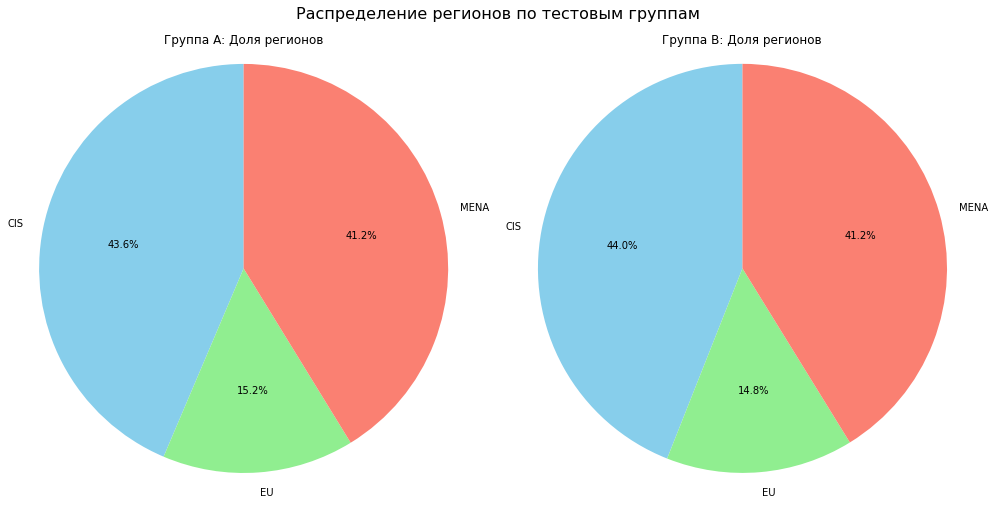

In [24]:
# Распределение по регионам (прописала метод nunique())
region_dist_a = group_a.groupby('region')['user_id'].nunique().sort_index()
region_dist_b = group_b.groupby('region')['user_id'].nunique().sort_index()

# Нормализуем, чтобы получить доли
region_dist_a = region_dist_a / region_dist_b.sum()
region_dist_b = region_dist_b / region_dist_b.sum()

# Создадим словарь цветов для регионов
region_colors = {
    'CIS': 'skyblue',
    'MENA': 'salmon',
    'EU': 'lightgreen'
}

# Создаём два графика рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Группа A - круговая диаграмма
axes[0].pie(
    region_dist_a.values,
    labels=region_dist_a.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[region_colors[region] for region in region_dist_a.index],
    textprops={'fontsize': 10}
)
axes[0].set_title('Группа A: Доля регионов')
axes[0].axis('equal')  

# Группа B - круговая диаграмма
axes[1].pie(
    region_dist_b.values,
    labels=region_dist_b.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[region_colors[region] for region in region_dist_b.index],
    textprops={'fontsize': 10}
)
axes[1].set_title('Группа B: Доля регионов')
axes[1].axis('equal')  

# Общий заголовок
fig.suptitle('Распределение регионов по тестовым группам', fontsize=16)

# Показываем график
plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем выводы:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

#### Выводы по проведенному анализу A/В-теста

**Равенство количества пользователей в группах соблюдено**:
- Общее число уникальных пользователей за первый день: `1477 + 1466 = 2943`
- Пользователи распределены равномерно между группами `A` и `В`.
- Процентная разница между группами `0.74%` - мала, следовательно было произведено правильное разделение трафика.

**Независимость выборок**:
- Количество пользователей, попавших и в группу А, и в группу В - `0`.
- Пересечений не обнаружено, выборки являются независимыми.

**Распределение пользователей по категориям**:

а) Типы устройств - распределение по типу устройств очень схожее в обеих группах, единственно `доля Android-пользователей` чуть выше в `группе В ~2%`.

б) Регионы - распределение по регионам также близко, единственно `группа В` имеет немного больше пользователей из `CIS ~0.4%`, доля `MENA` одинакова и доля `EU` чуть ниже в группе В `~0.4%`.

**А/В-тест проходит корректно**:
- `Количество пользователей в группах близко, процентная разница мала`.
- `Выборки независимы`.
- `Распределение категориальных переменных сбалансировано`.
- `Нет систематических различий между группами, которые могли бы исказить результаты теста`.

### 4. Проверка результатов A/B-теста

Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраняем в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей.

- В датафрейме `sessions_test` создаем дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [25]:
# Считываем данные из csv
sessions_test = pd.read_csv(.............................)

# Выводим строки датафрейма на экран
(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [26]:
# Выводим информацию о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


In [27]:
# Переводим нужные столбцы в формат "дата"
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date']).dt.normalize()
sessions_test['install_date'] = pd.to_datetime(sessions_test['install_date']).dt.normalize()

# Переводим нужный столбец в формат "дата и время"
sessions_test['session_start_ts'] = pd.to_datetime(sessions_test['session_start_ts'])

In [28]:
# Проверяем типы данных
(sessions_test.dtypes)

user_id                      object
session_id                   object
session_date         datetime64[ns]
session_start_ts     datetime64[ns]
install_date         datetime64[ns]
session_number                int64
registration_flag             int64
page_counter                  int64
region                       object
device                       object
test_group                   object
dtype: object

In [29]:
# Создаем новый столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

Необходимо убедиться, что тест проведён корректно, сравним две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведем на экран полученное значение p-value и интерпретируем его.

In [30]:
# Группируем данные по дате и тестовой группе, считаем число уникальных сессий
daily_sessions = (
    sessions_test
    .groupby(['session_date', 'test_group'])['session_id']
    .nunique()
    .unstack(fill_value=0)    
)

# Берем значения по группам
group_a_daily = daily_sessions['A'].values
group_b_daily = daily_sessions['B'].values

# Выполняем t-test
t_stat, p_value = ttest_ind(
    group_a_daily,
    group_b_daily
)

# Уровень значимости
alpha = 0.05

# Выводим гипотезы и результат
print(f"Результат t-теста:")
print(f"-> t-статистика: {t_stat:.4f}")

if p_value > alpha:
    print(f"-> p-value = {p_value:.4f} > {alpha} -> Не можем отвергнуть H₀")
    print('-> Среднее число уникальных сессий в группа А равно среднему числу сессий в день в группе В -> группы не отличаются по активности.')
else:
    print(f"-> p-value = {p_value:.4f} < {alpha} -> Отвергаем H₀")
    print('-> Среднее число уникальных сессий в группах А и В различается -> группы несбалансированы.')

Результат t-теста:
-> t-статистика: -0.0780
-> p-value = 0.9382 > 0.05 -> Не можем отвергнуть H₀
-> Среднее число уникальных сессий в группа А равно среднему числу сессий в день в группе В -> группы не отличаются по активности.


#### Промежуточные выводы

Для проверки корректности А/В-теста была проведена статистическая проверка равенства средних числа уникальных сессий в день между группами А и В.

Были сформулированы следующие гипотезы:
- H₀: Среднее число уникальных сессий в день в группах A и B не отличается.
- H₁: Среднее число уникальных сессий в день в группах A и B отличается.

Результат t-теста `p_value = 0.9382 > 0.05`, это значит:
+ **Нет статистически значимой разницы** в числе сессий между группами `А` и `В`.
+ Трафик **распределен равномерно**.
+ A/B-тест **спланирован корректно**.

#### 4.3. Сравнение доли успешных сессий

Используем созданный на первом шаге столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [31]:
# Рассчитаем доли успешных сессий
good_sessions_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
good_sessions_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()

# Разница между группами
diff = good_sessions_b - good_sessions_a

# Выводим результат
print(f"Доля успешных сессий в группе А: {good_sessions_a:.4f}")
print(f"Доля успешных сессий в группе В: {good_sessions_b:.4f}")
print(f"Разница (B - A): {diff:.4f}")

Доля успешных сессий в группе А: 0.3077
Доля успешных сессий в группе В: 0.3183
Разница (B - A): 0.0106


#### 4.4. Насколько статистически значимо изменение ключевой метрики

Количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, однако делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведем на экран полученное значение p-value и свои выводы о статистической значимости. Уровень значимости был выбран на уровне 0.05.

In [32]:
# Фильтруем данные по группам
group_a = sessions_test[sessions_test['test_group'] == 'A']
group_b = sessions_test[sessions_test['test_group'] == 'B']

# Считаем число успешных сессий и общее число сессий 
m_a = group_a['good_session'].sum()
n_a = len(group_a)

m_b = group_b['good_session'].sum()
n_b = len(group_b)

# Выполняем z-test для долей, т.к наша метрика - бинарная
count = [m_a, m_b]
nobs = [n_a, n_b]

z_stat, p_value = proportions_ztest(count,nobs)

# Уровень значимости
alpha = 0.05

# Выводим гипотезы и результат
print(f"Результат z-теста:")
print(f"-> z-статистика: {z_stat:.4f}")

if p_value > alpha:
    print(f"-> p-value = {p_value:.4f} > {alpha} -> -> Не можем отвергнуть H₀, недостаточно доказательств, чтобы утверждать, что группы отличаются.")
    print("-> Доли успешных сессий в группах А и В равны, новый алгоритм не влияет на вовлечённость.")
else:
    print(f"-> p-value = {p_value:.4f} < {alpha} -> Отвергаем H₀, достаточно доказательств, чтобы утверждать, что группы отличаются.")
    print("-> Доли успешных сессий в группах А и В различаются, новый алгоритм влияет на вовлечённость.")

Результат z-теста:
-> z-статистика: -3.6027
-> p-value = 0.0003 < 0.05 -> Отвергаем H₀, достаточно доказательств, чтобы утверждать, что группы отличаются.
-> Доли успешных сессий в группах А и В различаются, новый алгоритм влияет на вовлечённость.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируем следующие выводы для команды разработки приложения:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

#### Вывод для команды разработки приложения

- Цель теста: оценить **эффективность нового алгоритма рекомендаций**.
- Целевая метрика: доля сессий, в которых пользователь просмотрел **4 и более страниц - показатель вовлеченности контента**.
- Гипотеза: новый алгоритм повысит вовлеченность пользователь -> **увеличит долю "успешных сессий"**.

Параметры теста
- Уровень значимости alpha = `0.05`.
- Мощность теста power = `0.8`.
- Минимальный детектируемый эффект MDE = `+3%  к базовой конверсии`.
- Необходимый размер выборки на группу = `17 441 уникальных пользователя`.
- Среднее количество пользователей в день = `~9907`.
- Длительность теста = `~4 дня`.

Результаты проверки корректности А/В-теста

✅ Равномерное распределение пользователей по группам.
- Группа А = `1477 пользователей`.
- Группа В = `1466 пользователей`.
- Процентная разница между группами = `0.74% - мала, трафик распределен правильно`.

✅ Независимость выборок
- Количество пользователей, попавших и в группу А, и в группу В = `0`.
- Выборки независимы -> `тест проведен корректно`.

✅ Баланс по категориям
- Распределение по типам устройств схожее, группа В имеет на `~2% больше Android-пользователей`.
- Распределение по регионам близкое, группа В имеет на `~0.4% больше пользователей из CIS и на ~0.4% меньше пользователей из EU`.

`Различия несущественны и не должны влиять на результаты теста`.

✅ Активность пользователей по дням
- Была рассчитана ежедневная активность пользователей.
- Проведен `t-test` на равенство средних числа сессий в день.
- `p-value = 0.9382 > 0.05`, из этого следует, что нет статистически значимых различий между группами по количеству сессий в день.

✅ Результаты по целевой метрики
- А (контрольная) = `0.3077 (30.77%)`.
- В (тестовая) = `0.3183 (31.83%)`.
- Разница = `+1.06 п.п.(+3.45%)`.


✅ Результаты z-test
- Проведен `z-test` для пропорций, значение `p_value = 0.0003 < 0.05`, то есть **отвергаем нулевую гипотезу о равенстве долей**.

`Увеличение доли успешных сессий в группе В является статистически значимым и не случайным`.

✅ Рекомендация команде разработки
- **Новый алгоритм рекомендаций стоит внедрить в продукт, так как он статистически значимо увеличивает вовлеченность пользователей и улучшает целевую метрику**.